In [2]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import random
from helper_functions import *

# Time Series & Forecasting

A *time series* is a specific type of data, where measurements of a single quantity are taken over time.

"A time series is a sequence of random variables, $x_1, x_2, x_3, ...$, where the random variable $x_1$ denotes the value taken by the series at the first time point...

The collection of random variables, {$x_t$}, indexed by $t$ is referred to as a *stochastic process*. $t$ in this sense is discrete and varies over integers $t = 0, \pm1, \pm2, \pm3, ...$, or some subset of integers." -- *Time Series Statistical Models*

*Some thinking out loud*

So we can approach time series & forecasting in two ways, as a statistician, or as a computer... The first option, as a statistician, requires we think of the time series values as *counts*, which are poisson distributed. If we looked at a monetary value, it would be (log)-normally distributed. This process would lead to an Arima/Sarimax model which is some branch of Linear Regression, therefore is more complicated to satisfy all of the regression assumptions.

If we instead wanted to fancy ourselves computers, we could throw the counts or monetary values (really whatever) to a neural net like FB's Prophet since neural nets do not care to understand distributions.

---

## The Problem

Kaggle Comp: [M5 Forecasting - Accuracy: Estimate the unit sales of Walmart retail goods](https://www.kaggle.com/c/m5-forecasting-accuracy/data)

* Predicting item sales at Wallmart stores in California, Texas, and Wisconsin for two 28-day time periods.

First there's some merging/cleaning/exploring... we start with three csvs:

1. `sales_train_evaluation.csv`
2. `calendar.csv`
3. `sell_prices.csv`

## Exploratory Data Analysis
---

In [4]:
train_sales = pd.read_csv("../data/sales_train_evaluation.csv")
calendar = pd.read_csv("../data/calendar.csv")
sell_prices = pd.read_csv("../data/sell_prices.csv")

In [5]:
train_sales.shape, calendar.shape, sell_prices.shape

((30490, 1947), (1969, 14), (6841121, 4))

#### Starting with `train_sales`

In [6]:
train_sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [7]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [8]:
categorical_cols = train_sales.select_dtypes(include=['object'])

for col in categorical_cols:
    print(f'{col}:\n{np.unique(train_sales[col], return_counts=True)}\n')

id:
(array(['FOODS_1_001_CA_1_evaluation', 'FOODS_1_001_CA_2_evaluation',
       'FOODS_1_001_CA_3_evaluation', ...,
       'HOUSEHOLD_2_516_WI_1_evaluation',
       'HOUSEHOLD_2_516_WI_2_evaluation',
       'HOUSEHOLD_2_516_WI_3_evaluation'], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

item_id:
(array(['FOODS_1_001', 'FOODS_1_002', 'FOODS_1_003', ...,
       'HOUSEHOLD_2_514', 'HOUSEHOLD_2_515', 'HOUSEHOLD_2_516'],
      dtype=object), array([10, 10, 10, ..., 10, 10, 10]))

dept_id:
(array(['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2'], dtype=object), array([2160, 3980, 8230, 4160, 1490, 5320, 5150]))

cat_id:
(array(['FOODS', 'HOBBIES', 'HOUSEHOLD'], dtype=object), array([14370,  5650, 10470]))

store_id:
(array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object), array([3049, 3049, 3049, 3049, 3049, 3049, 3049, 3049, 3049, 3049]))

state_id:
(array(['CA', 'TX', 'WI'], dtype=objec

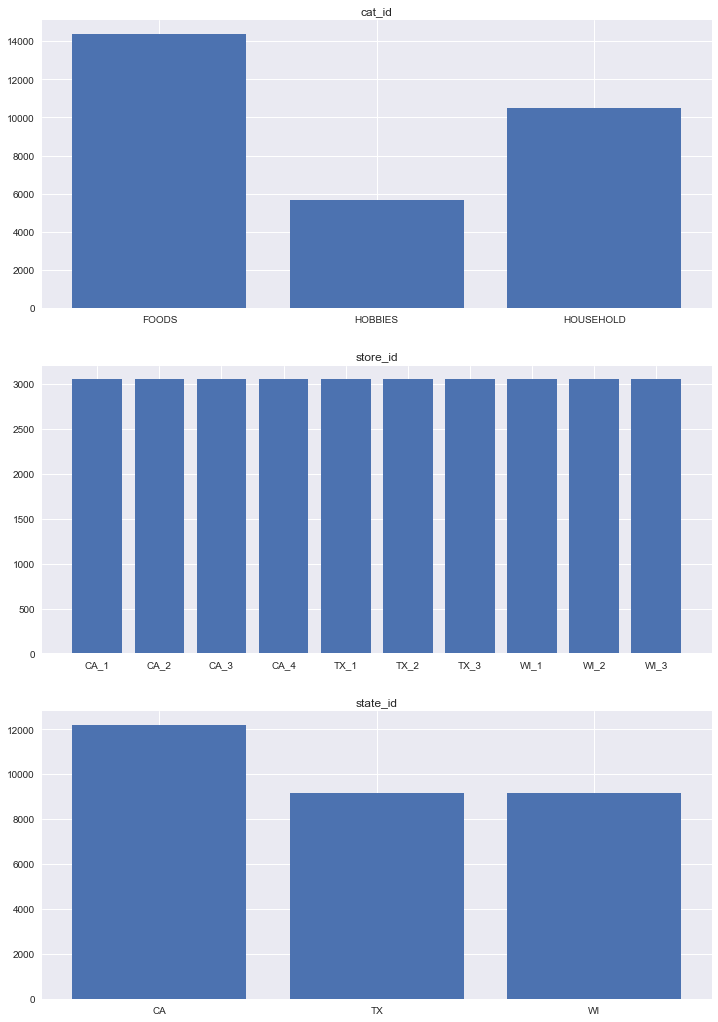

In [9]:
columns = ['cat_id', 'store_id', 'state_id']

x = []
y = []

for col in columns:
    values, counts = np.unique(train_sales[col], return_counts=True)
    x.append(values)
    y.append(counts)

fig, ax = plt.subplots(3, figsize=(12, 18))
for i, ((xi, yi), col) in enumerate(zip(zip(x, y), columns)):
    ax[i].bar(xi, yi)
    ax[i].set_title(col);

#### Next `calendar`

In [10]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [11]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [12]:
fig = plot_missing_values(calendar, 'Calendar')
fig.show()

In [13]:
to_drop = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
calendar.drop(to_drop, axis=1, inplace=True)

In [14]:
categorical_cols = calendar.select_dtypes(include=['object'])

for col in categorical_cols:
    print(f'{col}:\n{np.unique(calendar[col], return_counts=True)}\n')

date:
(array(['2011-01-29', '2011-01-30', '2011-01-31', ..., '2016-06-17',
       '2016-06-18', '2016-06-19'], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

weekday:
(array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object), array([281, 281, 282, 282, 281, 281, 281]))

d:
(array(['d_1', 'd_10', 'd_100', ..., 'd_997', 'd_998', 'd_999'],
      dtype=object), array([1, 1, 1, ..., 1, 1, 1]))



#### Lastly `sell_prices`

In [15]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [16]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


## Thoughts on moving forward...

* `train_sales` rows are products, columns are days - looks like a pivoted dataframe, which makes it hard to merge/join with the `calendar`
* Can melt `train_sales` to create an *un-pivoted* table using [`pd.melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)
* There is a total of 1913 days = 5 years; 2011 - 2016
* `calendar` rows are days with timeseries object in `date` column
* Can merge `sell_price.item_id` with `train_sales.item_id` to add `sell_price`
* The last bullet doesn't sound as appealing bc most forecasting problems are for inventory *demand*

In [17]:
train_sales.head(2)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   d_97  d_98  d_99  d_100  d_101  d_102  d_103  d_104  d_105  d_106  d_107  \
0     0     0     0      0      0      0      0      0      0      0      0   
1     0     0     0      0      0      0      0      0      0      0      0   

   d_108  d_109  d_110  d_111  d_112  d_113  d_114  d_115  d_116  d_117  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   

   d_118  d_119  d_120  d_121  d_122  d_123  d_124  d_125  d_126  d_127  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   

   d_128  d_129  d_130  d_131  d_132  d_133  d_134  d_135  d_136  d_137  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   

   d_138  d_139  d_140  d_141  d_142  d_143  d_144  d_145  d_146  d_147  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      1      0      0      1   

   d_148  d_149  d_150  d_151  d_152  d_153  d_154  d_155  d_156  d_157  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      1      1      0      1      0   

   d_158  d_159  d_160  d_161  d_162  d_163  d_164  d_165  d_166  d_167  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      1      0      0      0      1      0      0   

   d_168  d_169  d_170  d_171  d_172  d_173  d_174  d_175  d_176  d_177  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      1      0   

   d_178  d_179  d_180  d_181  d_182  d_183  d_184  d_185  d_186  d_187  \
0      0      0      0      0      0  

In [18]:
calendar.head(2)

date  wm_yr_wk   weekday  wday  month  year    d  snap_CA  snap_TX  \
0  2011-01-29     11101  Saturday     1      1  2011  d_1        0        0   
1  2011-01-30     11101    Sunday     2      1  2011  d_2        0        0   

   snap_WI  
0        0  
1        0

In [19]:
train_sales_melt = pd.melt(train_sales, 
            id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
            var_name='d', value_name='item_sales')

In [20]:
train_sales_melt.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  item_sales  
0       CA  d_1           0  
1       CA  d_1           0  
2       CA  d_1           0  
3       CA  d_1           0  
4       CA  d_1           0

In [21]:
df = pd.merge(train_sales_melt, calendar, on='d')

In [22]:
to_drop = ['weekday', 'wday', 'month', 'year']
df.drop(to_drop, axis=1, inplace=True)
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  item_sales        date  wm_yr_wk  snap_CA  snap_TX  snap_WI  
0       CA  d_1           0  2011-01-29     11101        0        0        0  
1       CA  d_1           0  2011-01-29     11101        0        0        0  
2       CA  d_1           0  2011-01-29     11101        0        0        0  
3       CA  d_1           0  2011-01-29     11101        0        0        0  
4       CA  d_1           0  2011-01-29     11101        0        0        0

In [23]:
final = df.merge(sell_prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
final.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  item_sales        date  wm_yr_wk  snap_CA  snap_TX  snap_WI  \
0       CA  d_1           0  2011-01-29     11101        0        0        0   
1       CA  d_1           0  2011-01-29     11101        0        0        0   
2       CA  d_1           0  2011-01-29     11101        0        0        0   
3       CA  d_1           0  2011-01-29     11101        0        0        0   
4       CA  d_1           0  2011-01-29     11101        0        0        0   

   sell_price  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [24]:
df.shape, final.shape

((59181090, 13), (59181090, 14))

In [31]:
final = final.fillna(0)
final.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  item_sales        date  wm_yr_wk  snap_CA  snap_TX  snap_WI  \
0       CA  d_1           0  2011-01-29     11101        0        0        0   
1       CA  d_1           0  2011-01-29     11101        0        0        0   
2       CA  d_1           0  2011-01-29     11101        0        0        0   
3       CA  d_1           0  2011-01-29     11101        0        0        0   
4       CA  d_1           0  2011-01-29     11101        0        0        0   

   sell_price  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

## Plotting to identify trends
Plot by the various features to reveal insight. Will probably need to use [`resample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

* `state_id`
* `store_id`
* `cat_id`
* `dept_id`
* `item_id`

It's important to identify and remove trends to analyze a *stationary* series.

---
## Definitions
**Stationary**: (thinking as a statistician and not a computer) distributions of all equally spaced tuples (of any distance) are identical. In other words, the differences in the series steps are generated from the same distribution.

*The properties of the series DO NOT depend on when you begin observing it!*

**Trend**: gradual change in average level as time moves on. Can be *increasing*, *decreasing*, or *neither* (nonlinear - changes directions).
    * Recall regression models capture linear trends well to de-trend
    * For more complex trends, use moving average window to de-trend

**Seasonality**: a pattern that appears regularly, and aligns with features of the calendar. i.e. weekly, monthly, annually, quarterly, etc.

**Trend-Seasonal-Residual Decomposition**: We can express a time series as the sum of three components:
$$x_t = T_t + S_t + R_t$$

$T_t$ is the trend component. We can compute it using a moving average with window length determined by seasonality.

$S_t$ is the seasonal component of the *de-trended series* $x_t - T_t$. Obtain by averaging values in the same season (week, month, etc.)

$R_t$ is the remainder/error/residual of $x_t - T_t - S_t$

Use [statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

---

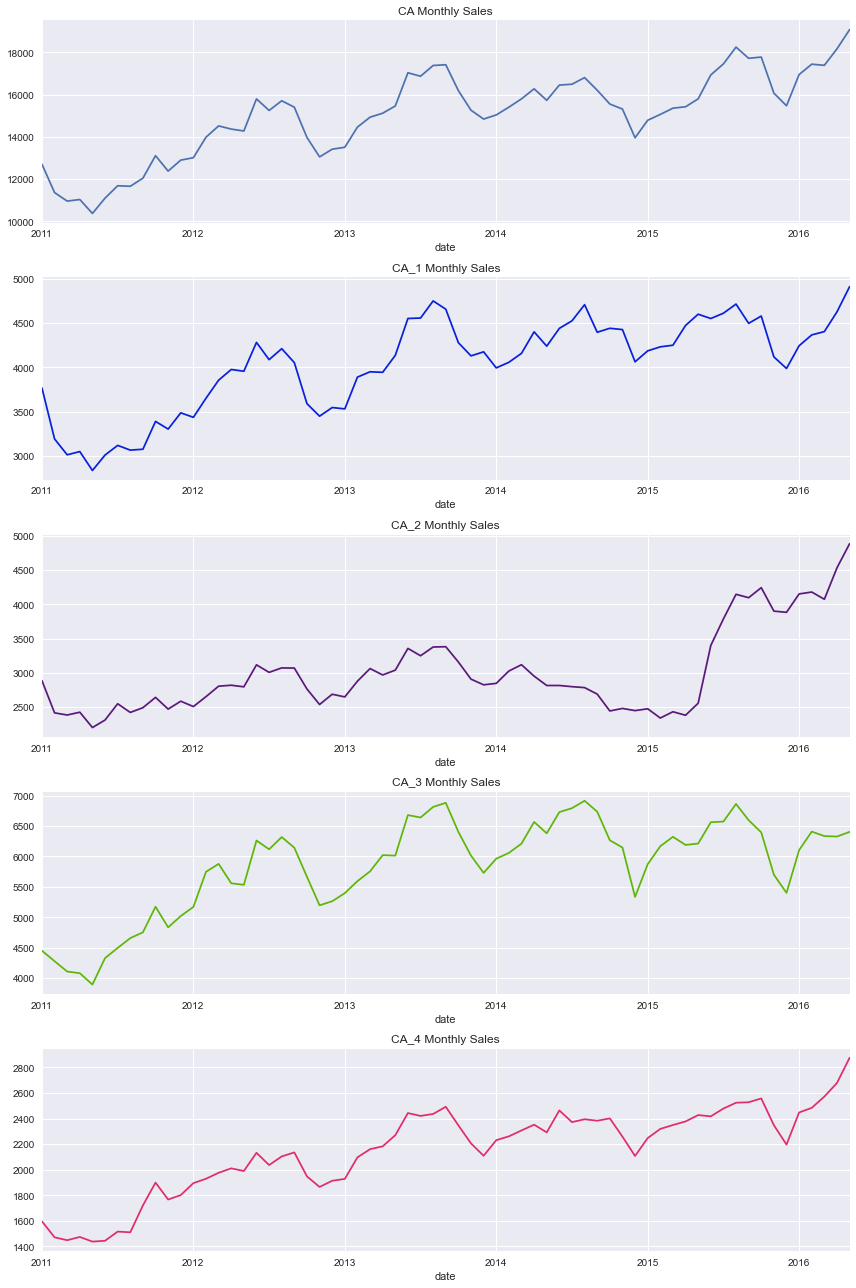

In [25]:
plot_state_sales(final, 'CA')
plt.tight_layout();

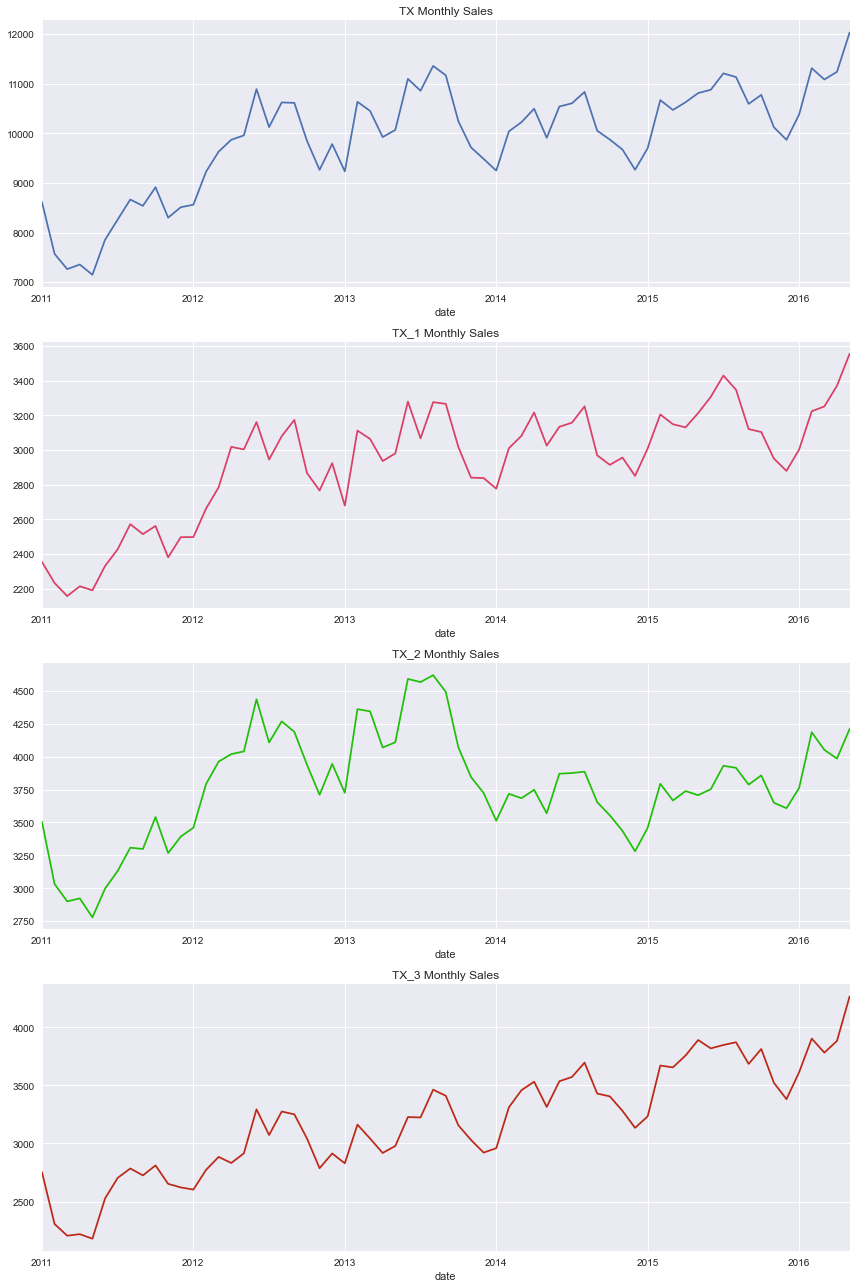

In [26]:
plot_state_sales(final, 'TX')
plt.tight_layout();

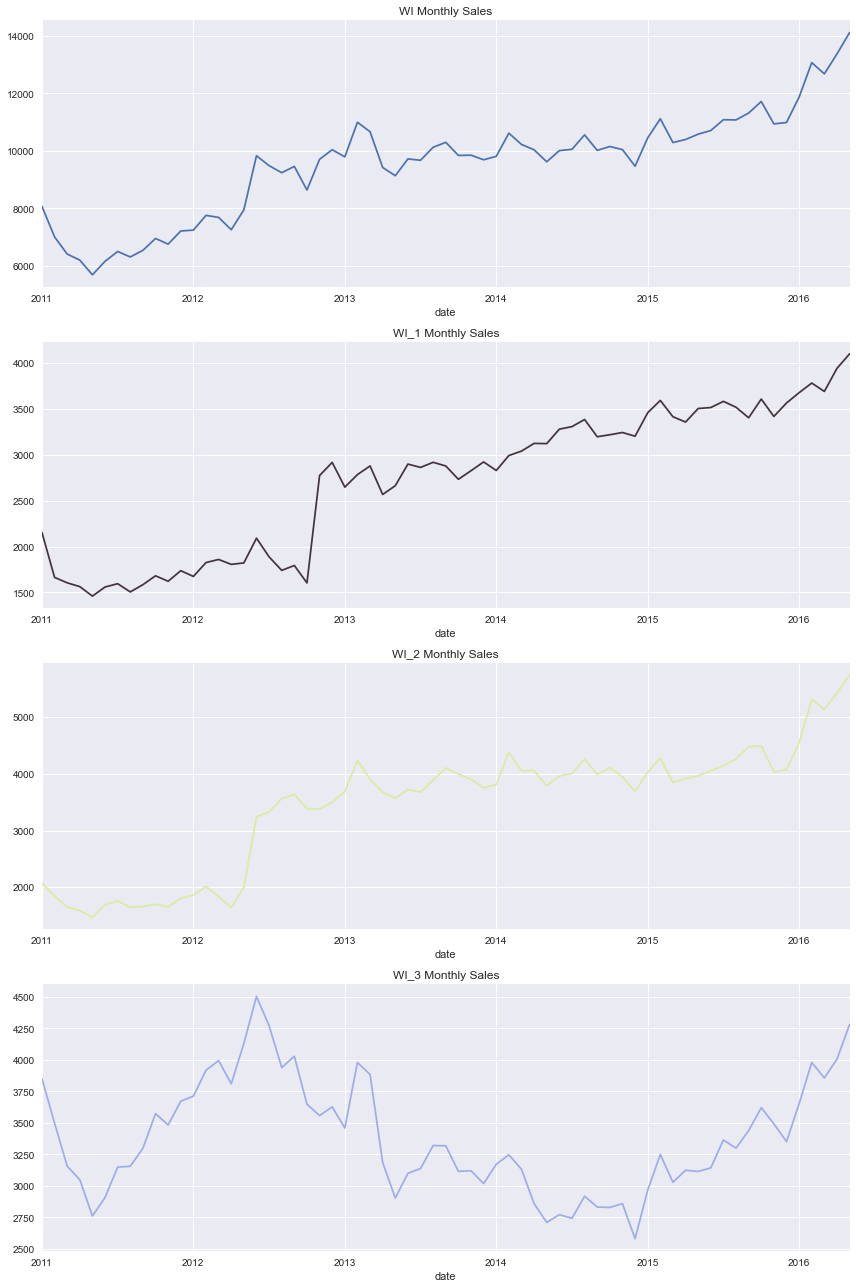

In [27]:
plot_state_sales(final, 'WI')
plt.tight_layout();

## Functions

#### Ideally for a demand/forecasting problem, we'd want to drill down to the department and item level to determine how much inventory we need.

* For exploring: `monthly_item_sales(df)`
* or use`sales(df, store= None, dept=None, item=None)`

Specify a state (case sensitive): ['CA' 'TX' 'WI'] 
CA
Specify a store: ['CA_1' 'CA_2' 'CA_3' 'CA_4'] 
CA_2
Choose a department category to view items available
['FOODS' 'HOBBIES' 'HOUSEHOLD'] 
HOBBIES
Plot department sales? Yes or No. 
No
HOBBIES_1_001
HOBBIES_1_002
HOBBIES_1_003
HOBBIES_1_004
HOBBIES_1_005
HOBBIES_1_006
Display more items? Yes or No. 
Yes
HOBBIES_1_007
HOBBIES_1_008
HOBBIES_1_009
HOBBIES_1_010
HOBBIES_1_011
Display more items? Yes or No. 
Yes
HOBBIES_1_012
HOBBIES_1_013
HOBBIES_1_014
HOBBIES_1_015
HOBBIES_1_016
Display more items? Yes or No. 
HOBBIES_1_015
Choose an item: 
HOBBIES_1_015


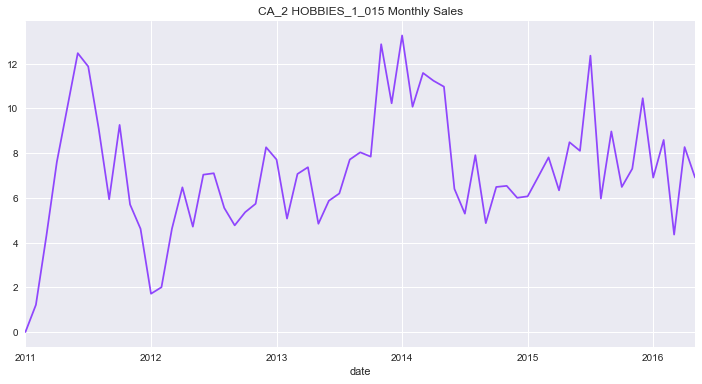

In [28]:
monthly_item_sales(final)

Specify a state (case sensitive): ['CA' 'TX' 'WI'] 
TX
Specify a store: ['TX_1' 'TX_2' 'TX_3'] 
TX_1
Choose a department category to view items available
['FOODS' 'HOBBIES' 'HOUSEHOLD'] 
HOBBIES
Plot department sales? Yes or No. 
Yes


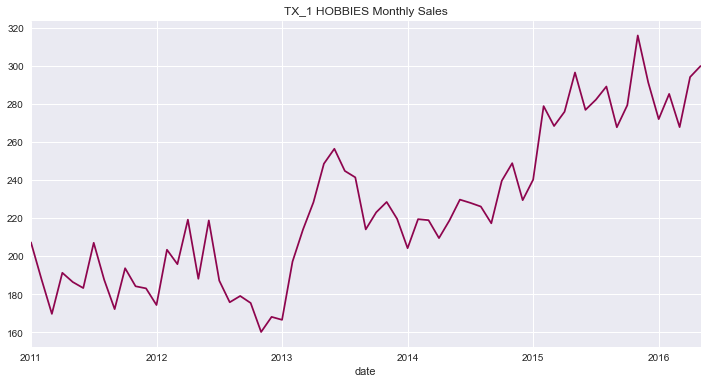

In [29]:
monthly_item_sales(final)

## Determining Stationarity & Prep for Modeling